In this kernel, we use efficientnet to complete the binary classification task. **This kernel is especially helpful if you are making an introduction to computer vision and deep learning in general**. In order to solve this challenge, the steps I take are the following:
1. Specify where the training and test folders are
2. Visualize a few images to know what data we're dealing with
3. Use Keras's ImageDataGenerator to augment the training data. If you haven't used this library before, or are new to data augmentation, take a look at this link: [http://keras.io/preprocessing/image/](http://)
4. We use a pre-trained model called EfficientNet. You don't need to know how this works. We just feed the data to the model we obtain online, and it gives us a good accuracy.
5. We finally make our predictions on the test images in the test zip file and format the submission.csv file to hold our own submissions!


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import os
from matplotlib import image
from matplotlib import pyplot
from numpy import asarray
from PIL import Image
import glob
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Any results you write to the current directory are saved as output.

['cropped-rfmid']


1. Installing pre-trained model - EfficientNet

In [2]:
!pip install -U efficientnet

You are using pip version 19.0.3, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


2. Specifying Train and Test directories

In [3]:
train_dir = '../input/cropped-rfmid/CROPPED/CROPPED'
test_dir = '../input/cropped-rfmid/CROPPED/CROPPED'
df = pd.read_csv('../input/cropped-rfmid/RFMiD_Training_Labels.csv')
df.head()

ID  Disease_Risk  DR  ARMD  MH  DN  ...    CRS  EDN  RPEC  MHL  RP  OTHER
0   1             1   1     0   0   0  ...      0    0     0    0   0      0
1   2             1   1     0   0   0  ...      0    0     0    0   0      0
2   3             1   1     0   0   0  ...      0    0     0    0   0      0
3   4             1   0     0   1   0  ...      0    0     0    0   0      0
4   5             1   1     0   0   0  ...      0    0     0    0   0      0

[5 rows x 30 columns]

In [4]:
import random

ARMD_samples = []
for i in range(1920):
  if df.loc[i]['ARMD'] == 1:
    ARMD_samples.append(i)
print(len(ARMD_samples))
selected_ARMD = random.sample(ARMD_samples,5)

BRVO_samples = []
for i in range(1920):
  if df.loc[i]['BRVO'] == 1:
    BRVO_samples.append(i)
print(len(BRVO_samples))
selected_BRVO = random.sample(BRVO_samples,5)

DR_samples = []
for i in range(1920):
  if df.loc[i]['DR'] == 1:
    DR_samples.append(i)
print(len(DR_samples))
selected_DR = random.sample(DR_samples,30)

not_at_risk_samples = []
for i in range(1920):
  if df.loc[i]['Disease_Risk'] == 0:
    not_at_risk_samples.append(i)
print(len(not_at_risk_samples))
selected_not_at_risk = random.sample(not_at_risk_samples,30)

MH_samples = []
for i in range(1920):
  if df.loc[i]['MH'] == 1:
    MH_samples.append(i)
print(len(MH_samples))
selected_MH = random.sample(MH_samples,20)

ODC_samples = []
for i in range(1920):
  if df.loc[i]['ODC'] == 1:
    ODC_samples.append(i)
print(len(ODC_samples))
selected_ODC = random.sample(ODC_samples,20)

DN_samples = []
for i in range(1920):
  if df.loc[i]['DN'] == 1:
    DN_samples.append(i)
print(len(DN_samples))
selected_DN = random.sample(DN_samples,138)

MYA_samples = []
for i in range(1920):
  if df.loc[i]['MYA'] == 1:
    MYA_samples.append(i)
print(len(MYA_samples))
selected_MYA = random.sample(MYA_samples,5)

TSLN_samples = []
for i in range(1920):
  if df.loc[i]['TSLN'] == 1:
    TSLN_samples.append(i)
print(len(TSLN_samples))
selected_TSLN = random.sample(TSLN_samples,10)
        
    
# for myopia

# 101 MYA
# 20 not at risk
# 25 DR
# 20 MH
# 10 DN
# 5 ARMD
# 18 ODC
# 5 BRVO
# 12 TSLN

100
73
376
401
317
282
138
101
186


In [5]:
import random

def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

df2 = pd.DataFrame(columns=['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN',
       'ERM', 'LS', 'MS', 'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST',
       'AION', 'PT', 'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'OTHER'])

df3 = pd.DataFrame(columns=['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN',
       'ERM', 'LS', 'MS', 'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST',
       'AION', 'PT', 'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'OTHER'])

final_train = set()
final_test = set()



DR_train = random.sample(selected_DR,21)
DR_test = Diff(selected_DR,DR_train)

not_at_risk_train = random.sample(selected_not_at_risk,21)
not_at_risk_test = Diff(selected_not_at_risk,not_at_risk_train)

MH_train = random.sample(selected_MH,14)
MH_test = Diff(selected_MH,MH_train)

ODC_train = random.sample(selected_ODC,14)
ODC_test = Diff(selected_ODC, ODC_train)

DN_train = random.sample(selected_DN,97)
DN_test = Diff(selected_DN, DN_train)

MYA_train = random.sample(selected_MYA,4)
MYA_test = Diff(selected_MYA, MYA_train)

BRVO_train = random.sample(selected_BRVO,4)
BRVO_test = Diff(selected_BRVO, BRVO_train)

TSLN_train = random.sample(selected_TSLN,7)
TSLN_test = Diff(selected_TSLN,TSLN_train)

ARMD_train = random.sample(selected_ARMD,4)
ARMD_test = Diff(selected_ARMD,ARMD_train)


In [6]:
final_train.update(ARMD_train)
final_train.update(BRVO_train)
final_train.update(TSLN_train)
final_train.update(DR_train)
final_train.update(not_at_risk_train)
final_train.update(MH_train)
final_train.update(ODC_train)
final_train.update(DN_train)
final_train.update(MYA_train)

final_test.update(ARMD_test)
final_test.update(BRVO_test)
final_test.update(TSLN_test)
final_test.update(DR_test)
final_test.update(not_at_risk_test)
final_test.update(MH_test)
final_test.update(ODC_test)
final_test.update(DN_test)
final_test.update(MYA_test)

df4 = df.to_dict('index')
for i in final_train:
  df2 = df2.append(df4[i],ignore_index = True)

for i in final_test:
  df3 = df3.append(df4[i],ignore_index = True)

print(len(df2))
print(len(df3))


182
77


In [7]:
df2.head()

ID Disease_Risk DR ARMD MH DN MYA  ...  RS CRS EDN RPEC MHL RP OTHER
0   515            1  0    0  1  0   0  ...   0   0   0    0   0  0     0
1  1028            1  0    1  0  0   0  ...   0   0   0    0   0  0     0
2     4            1  0    0  1  0   0  ...   0   0   0    0   0  0     0
3  1027            1  0    0  0  1   0  ...   0   0   0    0   0  0     0
4   519            1  0    1  0  1   0  ...   0   0   0    0   0  0     0

[5 rows x 30 columns]

In [8]:
import cv2

file_names_train = []
file_names_test = []

for i in final_train:
    file_names_train.append('cropped_' + str(i+1)+'.png')

    
for i in final_test:
    file_names_test.append('cropped_' + str(i+1)+'.png')


In [9]:
print(len(file_names_train))
print(len(file_names_test))

182
77


Takeout: Might be a little difficult to recognise between the two categories. Each image is 32x32 pixels. Now that we know the data we are dealing with, lets try to augment the data. Before that, Let's import a few libraries we need for our EfficientNet

In [10]:
df2 = df2.drop(columns=['ID','Disease_Risk','DR', 'MH', 'MYA', 'ARMD', 'BRVO', 'TSLN',
       'ERM', 'LS', 'MS', 'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST',
       'AION', 'PT', 'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'OTHER'])

df2['id'] = file_names_train

df3 = df3.drop(columns=['ID','Disease_Risk','DR', 'MH', 'MYA', 'ARMD', 'BRVO', 'TSLN',
       'ERM', 'LS', 'MS', 'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST',
       'AION', 'PT', 'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'OTHER'])

df3['id'] = file_names_test

df2.head()

DN                id
0  0   cropped_515.png
1  0  cropped_1028.png
2  0     cropped_4.png
3  1  cropped_1027.png
4  1   cropped_519.png

In [11]:
df2.head(50)

DN                id
0   0   cropped_515.png
1   0  cropped_1028.png
2   0     cropped_4.png
3   1  cropped_1027.png
4   1   cropped_519.png
5   1  cropped_1539.png
6   1    cropped_13.png
7   0   cropped_526.png
8   1    cropped_14.png
9   0  cropped_1040.png
10  1  cropped_1049.png
11  0  cropped_1052.png
12  1  cropped_1565.png
13  1  cropped_1054.png
14  1  cropped_1055.png
15  1  cropped_1056.png
16  0  cropped_1057.png
17  0    cropped_33.png
18  0  cropped_1567.png
19  0    cropped_37.png
20  0    cropped_40.png
21  0    cropped_46.png
22  0  cropped_1072.png
23  0  cropped_1586.png
24  1  cropped_1075.png
25  0   cropped_570.png
26  1   cropped_574.png
27  0  cropped_1090.png
28  1    cropped_67.png
29  1  cropped_1604.png
30  1   cropped_581.png
31  1  cropped_1091.png
32  1  cropped_1096.png
33  0  cropped_1097.png
34  0    cropped_73.png
35  0   cropped_585.png
36  0  cropped_1611.png
37  0  cropped_1610.png
38  0  cropped_1098.png
39  1  cropped_1099.png
40  0  cropped_1617.png
41  1  cropped_1107.png
42  0  cropped_1625.png
43  0   cropped_603.png
44  0    cropped_94.png
45  1    cropped_99.png
46  1   cropped_100.png
47  1  cropped_1132.png
48  1  cropped_1136.png
49  0   cropped_114.png

In [12]:
from keras import applications
from keras import callbacks
from keras.models import Sequential
import efficientnet.keras as effnet

Using TensorFlow backend.


In [13]:
df2['DN'] = df2['DN'].astype('str')
df3['DN'] = df3['DN'].astype('str')

Before we move on, a little explanation on ImageDataGenerator:
* we generate two generators - one for training, and another for validation. These are stored in train_generator and val_generator. For both, we apply a series of distortions. 
* However, instead of storing all these new images in a directory, we use the method **flow_from_dataframe** to dynamically load these images as we train the model
* However, all the distortions we made for train_gen are not applied to test_gen. This is because we don't want to augment the data in the test directory.

In [14]:
df3.head()

DN                id
0  0   cropped_899.png
1  1   cropped_390.png
2  0  cropped_1418.png
3  0  cropped_1805.png
4  0  cropped_1679.png

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = df2,
    directory = train_dir,
    x_col="id",
    y_col="DN",
    target_size=(32,32),
    subset="training",
    batch_size=64,
    shuffle=True,
    class_mode="binary"
)

Found 182 images belonging to 2 classes.


In [16]:
test_datagen = ImageDataGenerator(
    rescale=1/255
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = df3,
    directory = test_dir,
    x_col="id",
    y_col="DN",
    target_size=(32,32),
    batch_size=1,
    shuffle=False,
    class_mode="binary"
)

Found 77 images belonging to 2 classes.


Now, we used the pre-trained EfficientNet Model. The weights we used are the 'imagenet' weights. These weights are trained for object classification. This can really help our model because we don't have to train from scratch. 

This is the reason we set the include_top parameter of the EfficientNet to False. Essentially, we use the already trained initial layers - which detects lower-level features like edges, etc. Our EfficientNet is very good at this. We then replace the top layers with our own dense layers to recognise higher level features : like cactus or not. This is called **Transfer Learning**

For more on Transfer learning, see [https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html](http://)


In [17]:
from keras.layers import Dense
from keras.optimizers import Adam

efficient_net = effnet.EfficientNetB3(
    weights='imagenet',
    input_shape=(32,32,3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dense(units = 1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
44113920/44107200 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 1536)              10783528  
_________________________________________________________________
dense_1 (Dense)              (None, 120)               184440    
_________________________________________________________________
dense_2 (Dense)              (None, 120)               14520     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 121       
Total params: 10,982,609
Trainable params: 10,895

After we build or model, we compile it. We use Adam as the optimizer (safest choice)

In [18]:
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

Finally, we train the network with 51 epochs!

In [19]:
history = model.fit_generator(
    train_generator,
    epochs = 20,
    steps_per_epoch = 15
)

model.save("DN_MODEL.h5")

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
15/15 [==============================] - 113s 8s/step - loss: 0.7280 - acc: 0.5243
Epoch 2/20
15/15 [==============================] - 96s 6s/step - loss: 0.6669 - acc: 0.6068
Epoch 3/20
15/15 [==============================] - 95s 6s/step - loss: 0.6677 - acc: 0.6103
Epoch 4/20
15/15 [==============================] - 95s 6s/step - loss: 0.6415 - acc: 0.6335
Epoch 5/20
15/15 [==============================] - 95s 6s/step - loss: 0.6241 - acc: 0.6547
Epoch 6/20
15/15 [==============================] - 95s 6s/step - loss: 0.5967 - acc: 0.6778
Epoch 7/20
15/15 [==============================] - 95s 6s/step - loss: 0.5477 - acc: 0.7166
Epoch 8/20
15/15 [==============================] - 95s 6s/step - loss: 0.5177 - acc: 0.7304
Epoch 9/20
15/15 [==============================] - 95s 6s/step - loss: 0.5112 - acc: 0.7607
Epoch 10/20
15/15 [=================

Now that we have trained the network, let's plot the training vs validation accuracy and loss

From the plots, we see that the model has not overfit. Training and validation accuracy are almost the same. Now, lets generate our predictions

In [20]:
preds = model.predict_generator(
    test_generator,
    steps=len(test_generator.filenames)
)



In [21]:
image_ids = [name.split('/')[-1] for name in test_generator.filenames]
predictions = preds.flatten()
data = {'id': image_ids, 'DN':predictions} 
submission = pd.DataFrame(data)
print(submission.head())

                 id        DN
0   cropped_899.png  0.993063
1   cropped_390.png  0.992962
2  cropped_1418.png  0.989373
3  cropped_1805.png  0.010612
4  cropped_1679.png  0.986469


Finally, we generate the submission file! After this, go ahead and commit!

In [22]:
a = np.where(predictions > 0.5, 1, 0)
df3['DN'] = df3['DN'].astype(np.int)

import sklearn
cm = sklearn.metrics.confusion_matrix(df3['DN'].tolist(), a)
print(cm)

[[14 22]
 [ 8 33]]


--------------------------------------------------
Accuracy: 0.6103896103896104
Mis-Classification: 0.38961038961038963
Sensitivity: 0.8048780487804879
Specificity: 0.3888888888888889
Precision: 0.3888888888888889
f_1 Score: 0.5244040862656073


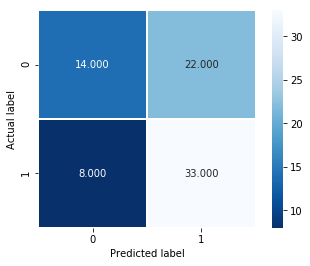

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure()
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');


TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
    
# calculate accuracy
conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
# calculate mis-classification
conf_misclassification = 1- conf_accuracy
    
# calculate the sensitivity
conf_sensitivity = (TP / float(TP + FN))
# calculate the specificity
conf_specificity = (TN / float(TN + FP))
    
# calculate precision
conf_precision = (TN / float(TN + FP))
# calculate f_1 score
conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
print('-'*50)
print(f'Accuracy: {conf_accuracy}') 
print(f'Mis-Classification: {conf_misclassification}') 
print(f'Sensitivity: {conf_sensitivity}') 
print(f'Specificity: {conf_specificity}') 
print(f'Precision: {conf_precision}')
print(f'f_1 Score: {conf_f1}')